# Raster-based market access

Following in the footsteps of the Malaria Atlas Project's <a href="https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2015_v1_0">Global Friction Surface</a>, this notebook explores a set of tools for calculating:

1. Travel time rasters
2. Drive-time polygons
3. Marketsheds


In [1]:
import sys, os, importlib
import rasterio
import overturemaps

import pandas as pd
import geopandas as gpd
import skimage.graph as graph

sys.path.append("C:/WBG/Work/Code/GOSTrocks/src")
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.mapMisc as mapMisc

sys.path.append("../../src")

import GOSTnetsraster.market_access as ma

%load_ext autoreload
%autoreload 2

GDAL is not installed - OGR functionality not available


In [2]:
iso3 = 'RWA'
m_crs = "ESRI:54009" # World Mollweide. Use epsg.io to search for other options

local_folder = f"C:/WBG/Work/Projects/HealthAccess/Tutorials/GNR/{iso3}"
results_folder = os.path.join(local_folder,"results") #os.path.join(base_folder, iso3)
least_cost_tt_file = os.path.join(results_folder, "least_cost_travel_time.tif")

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

aoi_file = os.path.join(local_folder, f'{iso3}_AOI_buffer.geojson')
dests = os.path.join(local_folder, f"{iso3}_cities.geojson")
# if you completed the friction surface generation step, you can also use:
friction_surface = os.path.join(local_folder, f"custom_friction_surface.tif")
friction_surface_proj = os.path.join(local_folder, f"custom_friction_surface_projected.tif")

In [3]:
global_boundaries = gpd.read_file("https://datacatalogfiles.worldbank.org/ddh-published-v2/0038272/5/DR0095369/World%20Bank%20Official%20Boundaries%20(GeoJSON)/World%20Bank%20Official%20Boundaries%20-%20Admin%200.geojson")
inA = global_boundaries.loc[global_boundaries['ISO_A3'] == iso3].to_crs(epsg=4326)
other_countries = global_boundaries.loc[global_boundaries['ISO_A3'] != iso3].to_crs(epsg=4326)

In [4]:
if not os.path.exists(dests):
    places = overturemaps.record_batch_reader("place", list(inA.total_bounds)).read_all()
    places_df = gpd.GeoDataFrame.from_arrow(places)
    places_df.crs = 4326
    # There are all kinds of places in here; filter to just airports, but you can examine others too
    #for lbl, x in places_df.basic_category.value_counts().items():
    #    print(lbl, x)
    places_df = places_df.loc[places_df.basic_category.isin(['airport'])]
    places_df = gpd.sjoin(places_df, inA, predicate='within', how='inner')
    places_df.to_file(dests, driver="GeoJSON")

In [5]:
inD = gpd.read_file(dests)
inR = rasterio.open(friction_surface)
if inR.crs != m_crs:
    if not os.path.exists(friction_surface_proj):
        res = rMisc.project_raster(inR, m_crs, friction_surface_proj)
    inR = rasterio.open(friction_surface_proj)
inD = inD.to_crs(inR.crs) # destinations and raster need to be in the same CRS

Skipping field websites: unsupported OGR type: 5
Skipping field socials: unsupported OGR type: 5
Skipping field phones: unsupported OGR type: 5


In [6]:
frictionD = inR.read()[0,:,:]
# convert friction surface to traversal time (lazily). Original data are
#    the original data are minutes to travel 1 m, so we will convert to 
#    minutes to cross the cell
frictionD = frictionD * inR.res[0]  # cell size in meters
mcp = graph.MCP_Geometric(frictionD)

In [7]:
ma.calculate_travel_time?

Signature: ma.calculate_travel_time(inH, mcp, destinations, out_raster='')
Docstring:
Calculate travel time from all cells to the set of destinations using an MCP graph

INPUTS
    inH [rasterio] - raster from which to grab index for calculations in MCP
    mcp [skimage.graph.MCP_Geometric] - input graph
    destinations [geopandas data frame] - geopandas data frame of destinations
    out_raster [string] - optional path to write travel time raster
RETURNS
    (costs [numpy array], traceback [numpy array])
File:      c:\wbg\work\code\gostnetsraster\src\gostnetsraster\market_access.py
Type:      function

In [8]:
travel_costs, traceback = ma.calculate_travel_time(inR, mcp, inD)
travel_costs = travel_costs.astype(inR.meta['dtype'])
with rasterio.open(least_cost_tt_file, 'w', **inR.meta) as out_file:
    out_file.write_band(1, travel_costs)

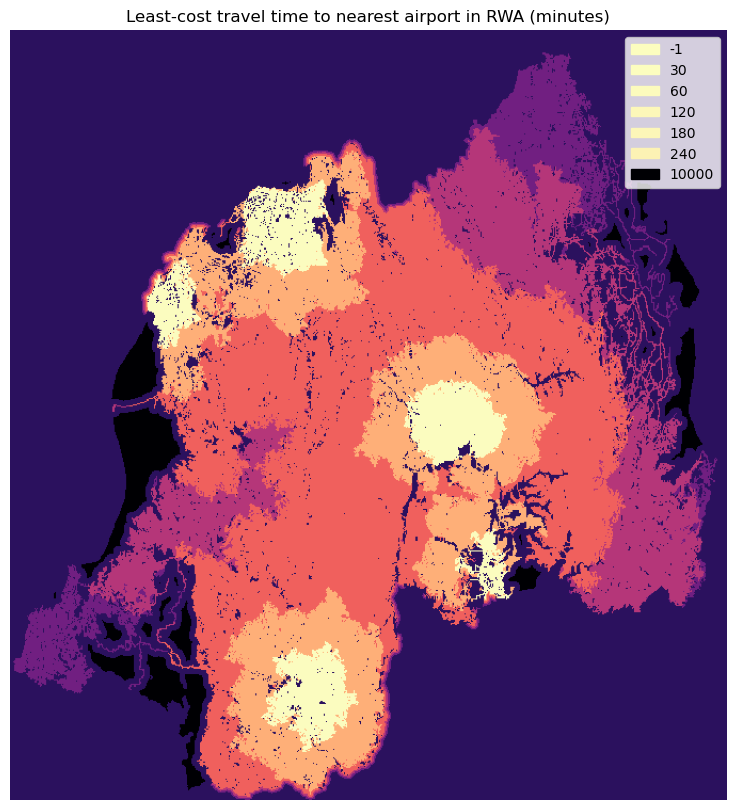

In [9]:
plt, fig, ax = mapMisc.static_map_raster(rasterio.open(least_cost_tt_file), thresh=[-1,30,60,120,180,240,10000], reverse_colormap=True)
ax.set_title(f"Least-cost travel time to nearest airport in {iso3} (minutes)")
ax.set_axis_off()

In [10]:
ma.generate_feature_vectors?

Signature:
ma.generate_feature_vectors(
    network_r,
    mcp,
    inH,
    threshold,
    featIdx='tempID',
    verbose=True,
)
Docstring:
Generate individual market sheds for each feature in the input dataset

INPUTS
    network_r [rasterio] - raster from which to grab index for calculations in MCP
    mcp [skimage.graph.MCP_Geometric] - input graph
    inH [geopandas data frame] - geopandas data frame from which to calculate features
    threshold [list of int] - travel treshold from which to calculate vectors in units of graph
    featIdx [string] - column name in inH to append to output marketshed dataset. 'tempID' for default.
    
RETURNS
    [geopandas dataframe]
File:      c:\wbg\work\code\gostnetsraster\src\gostnetsraster\market_access.py
Type:      function

In [11]:
drive_time_thresholds = [60, 120, 180, 240] # minutes
drive_vectors = ma.generate_feature_vectors(inR, mcp, inD, drive_time_thresholds)
drive_vectors.to_file(os.path.join(results_folder, "drive_vectors.shp"))

13:36:48	1 of 7: 0
13:36:49	2 of 7: 1
13:36:51	3 of 7: 2
13:36:54	4 of 7: 3
13:36:56	5 of 7: 4
13:36:58	6 of 7: 5
13:37:00	7 of 7: 6


In [12]:
drive_vectors.head()

,geometry,threshold,IDX
0,"MULTIPOLYGON (((2.95e+06 -2.12e+05, 2.95e+06 -...",60,0
1,"MULTIPOLYGON (((2.98e+06 -1.7e+05, 2.98e+06 -1...",120,0
2,"MULTIPOLYGON (((2.99e+06 -1.62e+05, 2.99e+06 -...",180,0
3,"MULTIPOLYGON (((2.99e+06 -1.62e+05, 2.99e+06 -...",240,0
4,"MULTIPOLYGON (((3.02e+06 -2.17e+05, 3.02e+06 -...",60,1


In [13]:
mapMisc.static_map_vector?

Signature:
mapMisc.static_map_vector(
    v_data,
    map_column,
    colormap='Reds',
    edgecolor='darker',
    reverse_colormap=False,
    thresh=None,
    legend_loc='upper right',
    figsize=(10, 10),
    out_file='',
    set_title=True,
    add_basemap=True,
    add_wb_borders_lines=True,
    iso3='',
    bbox=None,
    **kwargs,
)
Docstring:
Simple plot of vector data

Parameters
----------
v_data : geopandas.GeoDataFrame
    Input geopandas dataset to map
map_column : str
    Column label in v_data to map
colormap : str, optional
    Name of colour ramp to send to matplotlib.pyplot, by default "Reds"
edgecolor : str, optional
    Optional parameter to change edge colour of polygons.
    Optional values are match, darker, or a single provided colour, defaults to 'darker'
reverse_colormap : bool, optional
    Optionally reverse the colormap colorramp, defaults to False
thresh : list, optional
    List of thresholds to categorize values in v_data[map_column], defaults to equal i

In [ ]:
plt, fig, ax = mapMisc.static_map_vector(drive_vectors.loc[drive_vectors['threshold'] == 60], 
                                         map_column='IDX', add_basemap=False, add_wb_borders_lines=False)
ax.set_title(f"60 minute drive-time vectors")
ax.set_axis_off()

In [ ]:
ma.calculate_gravity?

In [ ]:
# calculate gravity to nearest cities, using the population column GC_POP_TOT_2025
gravity_col = "GC_POP_TOT_2025"
gravity_file = os.path.join(results_folder, f"gravity_cities_{gravity_col}.tif")
gravity = ma.calculate_gravity(inR, mcp, inD, gravity_col, outfile = gravity_file)

In [ ]:
with rMisc.create_rasterio_inmemory(inR.meta, gravity['gravity'][:,:,0]) as gravity_raster:
    mapMisc.static_map_raster(gravity_raster, thresh=[0,1000,5000,10000,50000,100000,500000], reverse_colormap=True)